In [1]:
import os
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from arch import arch_model
from scipy.stats import skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [84]:
# Load Bitcoin data from Yahoo Finance
btc_usd_ticker = 'BTC-USD'
eth_usd_ticker = 'ETH-USD'
sp500_ticker = '^GSPC'
vix_ticker = '^VIX'
gold_ticker = 'GC=F'
# Load data from Yahoo Finance
btc_data = yf.download(btc_usd_ticker, start="2010-01-01", end="2025-01-01")
eth_data = yf.download(eth_usd_ticker, start="2010-01-01", end="2025-01-01")
sp500_data = yf.download(sp500_ticker, start="2010-01-01", end="2025-01-01")
vix_data = yf.download(vix_ticker, start="2010-01-01", end="2025-01-01")
gold_data = yf.download(gold_ticker, start="2010-01-01", end="2025-01-01")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [85]:
# Remove the ticker level from the columns
btc_data.columns = btc_data.columns.droplevel(1)
eth_data.columns = eth_data.columns.droplevel(1)
sp500_data.columns = sp500_data.columns.droplevel(1)
vix_data.columns = vix_data.columns.droplevel(1)
gold_data.columns = gold_data.columns.droplevel(1)

In [86]:
btc_df = pd.DataFrame(btc_data)
eth_df = pd.DataFrame(eth_data)
sp500_df = pd.DataFrame(sp500_data)
vix_df = pd.DataFrame(vix_data)
gold_df = pd.DataFrame(gold_data)

In [92]:
# Check for missing values
print(btc_df.isnull().sum())
print(eth_df.isnull().sum())
print(sp500_df.isnull().sum())
print(vix_df.isnull().sum())

Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [93]:
# Log returns
btc_df['Return'] = np.log(btc_df['Close'] / btc_df['Close'].shift(1))
eth_df['Return'] = np.log(eth_df['Close'] / eth_df['Close'].shift(1))
sp500_df['Return'] = np.log(sp500_df['Close'] / sp500_df['Close'].shift(1))
vix_df['Return'] = np.log(vix_df['Close'] / vix_df['Close'].shift(1))
gold_df['Return'] = np.log(gold_df['Close'] / gold_df['Close'].shift(1))

In [94]:
btc_df.dropna(subset=['Return'], inplace=True)
eth_df.dropna(subset=['Return'], inplace=True)
sp500_df.dropna(subset=['Return'], inplace=True)
vix_df.dropna(subset=['Return'], inplace=True)
gold_df.dropna(subset=['Return'], inplace=True)

In [95]:
# Date to column
btc_df.reset_index(inplace=True)
eth_df.reset_index(inplace=True)
sp500_df.reset_index(inplace=True)
vix_df.reset_index(inplace=True)
gold_df.reset_index(inplace=True)

In [97]:
# Save to file
btc_df.to_csv('../data/btc_data.csv', index=False)
eth_df.to_csv('../data/eth_data.csv', index=False)
sp500_df.to_csv('../data/sp500_data.csv', index=False)
vix_df.to_csv('../data/vix_data.csv', index=False)
gold_df.to_csv('../data/gold_data.csv', index=False)

## EDA

In this section, we present an exploratory data analysis of daily returns for BTC, ETH, the S&P 500, the VIX, and Gold. The analysis includes time-series plots of returns, rolling volatility, return distributions, a correlation analysis, pairwise comparisons, and an examination of intraday price ranges. This allows us to compare the volatility and interdependence of cryptocurrencies against traditional assets, as motivated by our research question.

In [99]:
# Print current working directory to check location
print("Current working directory:", os.getcwd())

btc_df = pd.read_csv('../data/btc_data.csv', parse_dates=['Date'])
eth_df = pd.read_csv('../data/eth_data.csv', parse_dates=['Date'])
sp500_df = pd.read_csv('../data/sp500_data.csv', parse_dates=['Date'])
vix_df = pd.read_csv('../data/vix_data.csv', parse_dates=['Date'])
gold_df = pd.read_csv('../data/gold_data.csv', parse_dates=['Date'])
btc_df.set_index('Date', inplace=True)
eth_df.set_index('Date', inplace=True)
sp500_df.set_index('Date', inplace=True)
vix_df.set_index('Date', inplace=True)
gold_df.set_index('Date', inplace=True)
#print(btc_df.head())
#print(eth_df.head())
os.makedirs('eda_figures', exist_ok=True)

Current working directory: /Users/axelmender/Library/Mobile Documents/com~apple~CloudDocs/Documents/Courses/TIØ4317 Empirisk finans/TIO4317_Project_Assignment/src


# Time series plots of daily returns for each asset

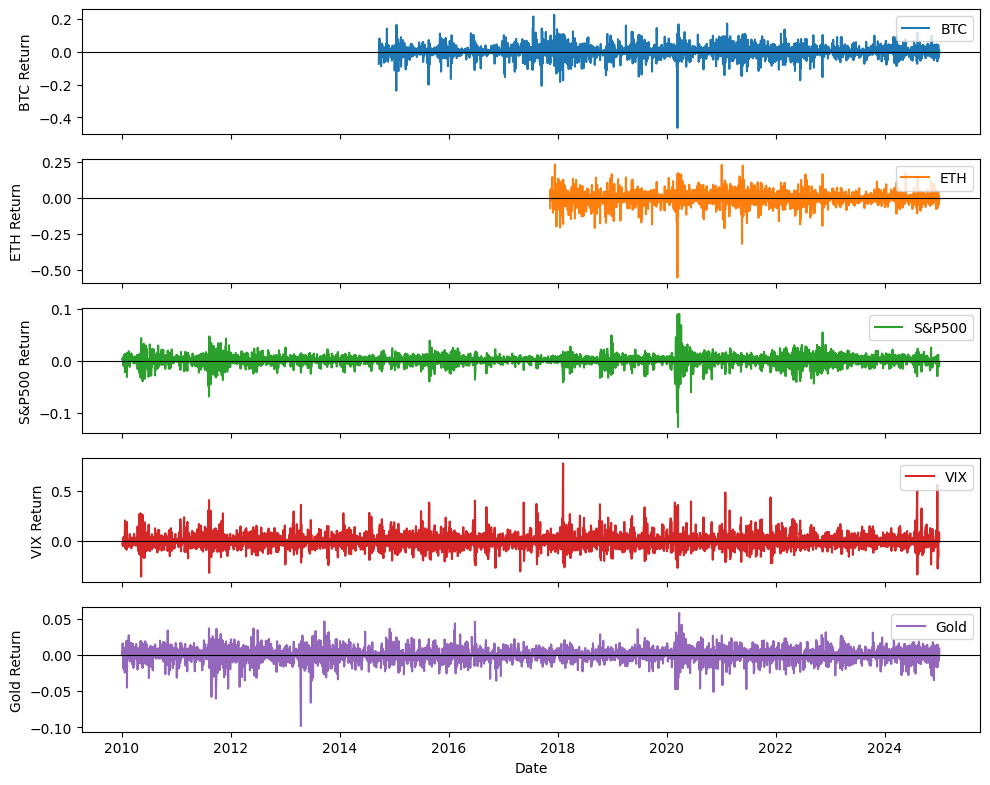

In [100]:
fig, axes = plt.subplots(5, 1, figsize=(10, 8), sharex=True)
assets = {'BTC': btc_df, 'ETH': eth_df, 'S&P500': sp500_df, 'VIX': vix_df, 'Gold': gold_df}
for i, (name, df) in enumerate(assets.items()):
    # If Date is a column, set it as index for plotting (if not already indexed by date)
    if 'Date' in df.columns:
        df = df.set_index('Date')
    axes[i].plot(df.index, df['Return'], label=name, color=f"C{i}")
    axes[i].axhline(0, color='black', linewidth=0.8)  # horizontal line at 0
    axes[i].set_ylabel(f'{name} Return')
    axes[i].legend(loc='upper right')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.savefig('eda_figures/returns_time_series.png', dpi=300)
plt.show()
plt.close()


As shown in the plot, Bitcoin and Ethereum have visibly higher volatility than the S&P 500, VIX, or Gold. This is quantified in the next plot, which is a 30-day rolling standard deviation for each return series. We see that the rolling volatility of BTC and ETH often spikes to values several times higher than those of the stock index or gold. These findings confirm that crypto assets are far more volatile on a daily basis. 

# Rolling 30-day volatility plots

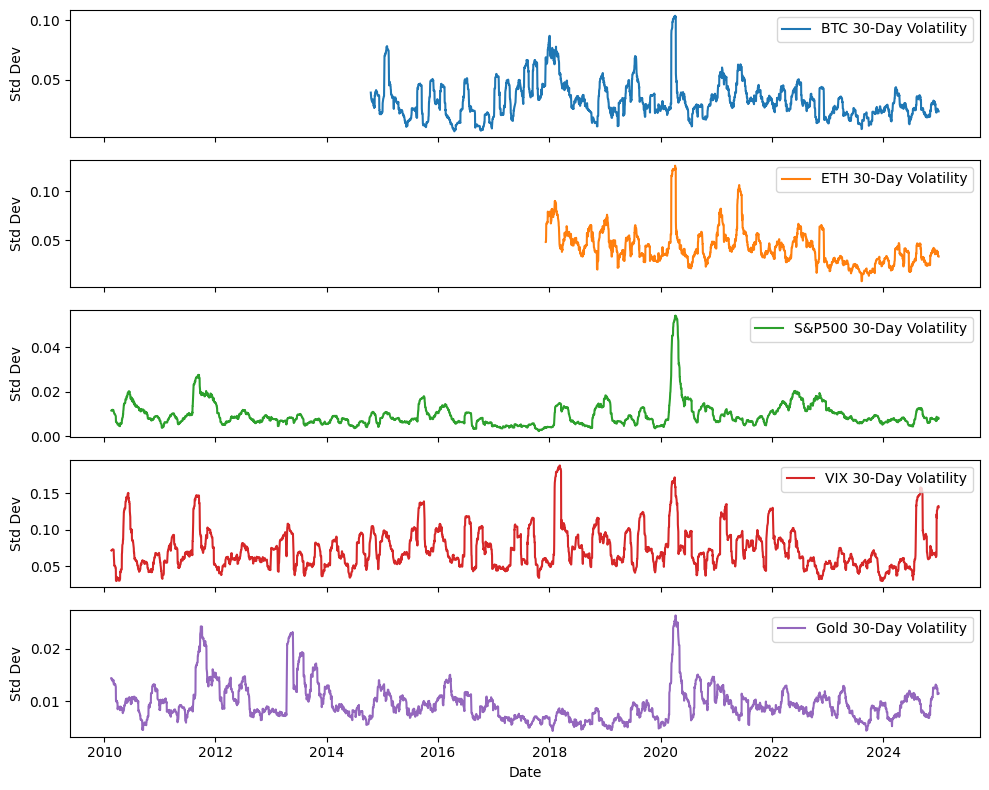

In [101]:
window = 30  # rolling window size (days)
fig, axes = plt.subplots(5, 1, figsize=(10, 8), sharex=True)
for i, (name, df) in enumerate(assets.items()):
    if 'Date' in df.columns:
        df = df.set_index('Date')
    rolling_vol = df['Return'].rolling(window).std()  # 30-day rolling std dev
    axes[i].plot(df.index, rolling_vol, label=f'{name} {window}-Day Volatility', color=f"C{i}")
    axes[i].set_ylabel('Std Dev')
    axes[i].legend(loc='upper right')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.savefig('eda_figures/rolling_volatility.png', dpi=300)
plt.show()
plt.close()

This plot shows a rolling 30-day volatility for each asset. Higher values indicate more volatile periods. BTC and ETH show significantly higher and more variable volatility over time compared to S&P 500 and Gold. The VIX has distinct spikes during market stress events. Volatility clustering is evident: periods of high volatility tend to persist for some time before reverting to calmer levels (Tsay, 2010, p. 273)

# Histograms and KDE plots of returns distribution

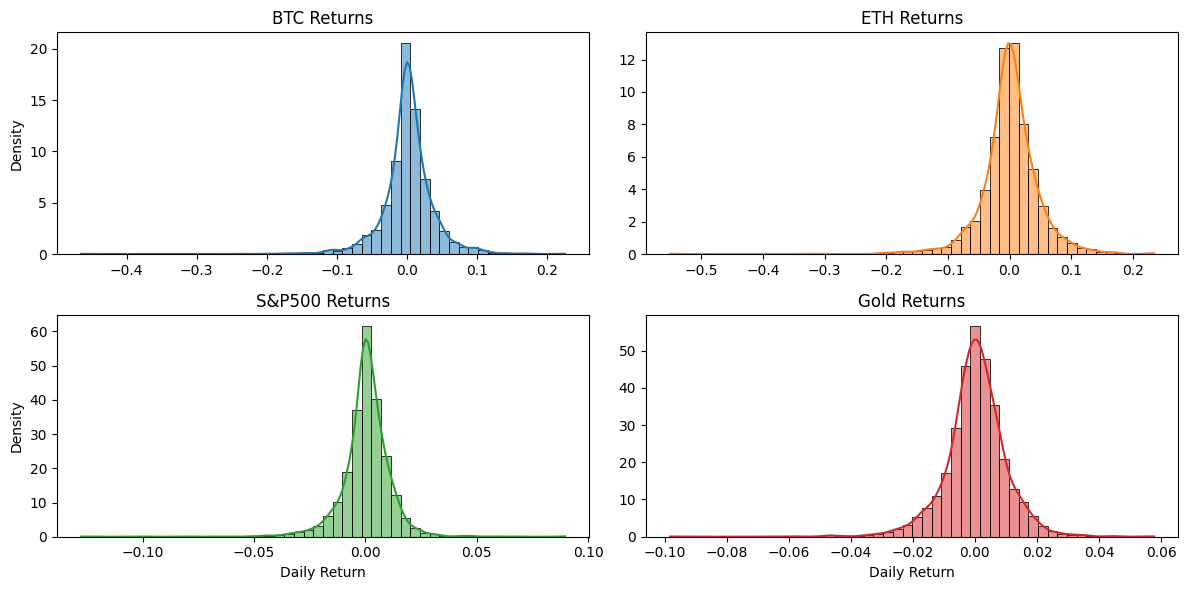

In [102]:
# Exclude VIX from the assets dictionary
filtered_assets = {k: v for k, v in assets.items() if k != 'VIX'}

# Create a 2x2 subplot for the four assets
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
asset_list = list(filtered_assets.items())

for idx, (name, df) in enumerate(asset_list):
    # Get the return series
    if 'Return' in df:
        r = df['Return'].dropna()
    else:
        r = df.dropna()
    
    # Determine subplot position in a 2x2 grid
    ax = axes[idx // 2, idx % 2]
    
    # Plot the histogram with KDE
    sns.histplot(r, kde=True, stat='density', bins=50, ax=ax, color=f"C{idx}")
    ax.set_title(f'{name} Returns')
    
    # Adjust axis labels
    if idx % 2 == 0:
        ax.set_ylabel('Density')
    else:
        ax.set_ylabel('')
        
    if idx // 2 == 1:
        ax.set_xlabel('Daily Return')
    else:
        ax.set_xlabel('')

plt.tight_layout()
plt.savefig('eda_figures/return_distribution.png', dpi=300)
plt.show()
plt.close()


Next, we examine the distribution of returns for each asset. The above plots shows histograms of daily returns with overlaid kernel density estimates (KDE). All assets exhibit a roughly symmetric distribution centered around zero mean, but with fat tails relative to a normal distribution. In particular, BTC and ETH relurns have very wide distributions indicating a higher frequency of both positive and negative. The S&P 500 and Gold returns are more tightly clustered around the mean. Statistically, the sample means of all these return series are close to zero. This is consistent with the idea that asset price changes are unpredictable on average. The return distributions are leptokurtic, showing high kurtosis (peaked center and fat tails). This means there are more extreme outcomes than one would expect under a normal distribution (Tsay, 2010, p. 315). Such fat-tailed behavior implies a higher probability of large losses or gains in cryptos. The distributions are also nearly symmetric with slight skewness. Especially crypto returns show a slight negative skew, indicating a tendency for sudden large drops to occur more often than equally large jumps.


# Correlation matrix and heatmap between the return series

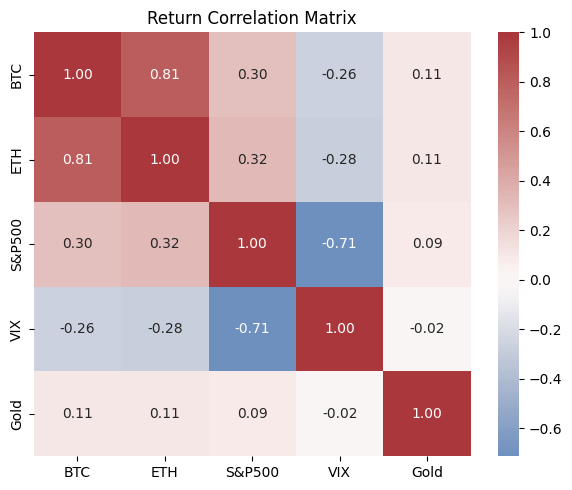

In [103]:
#First, align all return series by date into a single DataFrame
#Since each asset DataFrame already has Date as the index, you can directly reference the 'Return' column:

combined = pd.DataFrame({
    'BTC': assets['BTC']['Return'],
    'ETH': assets['ETH']['Return'],
    'S&P500': assets['S&P500']['Return'],
    'VIX': assets['VIX']['Return'],
    'Gold': assets['Gold']['Return']
})

combined = combined.dropna()  # drop dates where any is NaN (to align the data)
corr_matrix = combined.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="vlag", center=0, fmt=".2f")
plt.title('Return Correlation Matrix')
plt.tight_layout()
plt.savefig('eda_figures/correlation_heatmap.png', dpi=300)
plt.show()
plt.close()

We also analyze the interdependence between these assets. The plot shows a correlation heatmap of the daily returns. We find several insights. BTC and ETH returns are positively correlated with each other since both are cryptocurrencies in the same asset class, whereas their correlations with traditional assets are low. In our sample, BTC and ETH show little correlation with Gold, which is a traditional “safe-haven” asset, and only modest correlation with the S&P 500. This suggests that, historically, cryptocurrencies may offer diversification benefits since their price movements are relatively independent of stock and gold returns on a daily basis. Gold and S&P 500 have a very low or slightly negative correlation, consistent with gold’s role as a diversification asset against equities. As expected, the S&P 500 and VIX are strongly negatively correlated since VIX tends to spike when stock prices plunge. We note that correlations among assets are not static  during periods of market turmoil, asset correlations can change. In fact, it has been observed that correlations between markets tend to increase in a crisis (Tsay, 2010, p. 541). Our analysis only capturess linear correlations over the full sample. Deeper analysis could examine rolling correlations to see how crypto-traditional asset move during stress events.

# Pairwise scatterplots of returns (crypto vs. traditional assets)

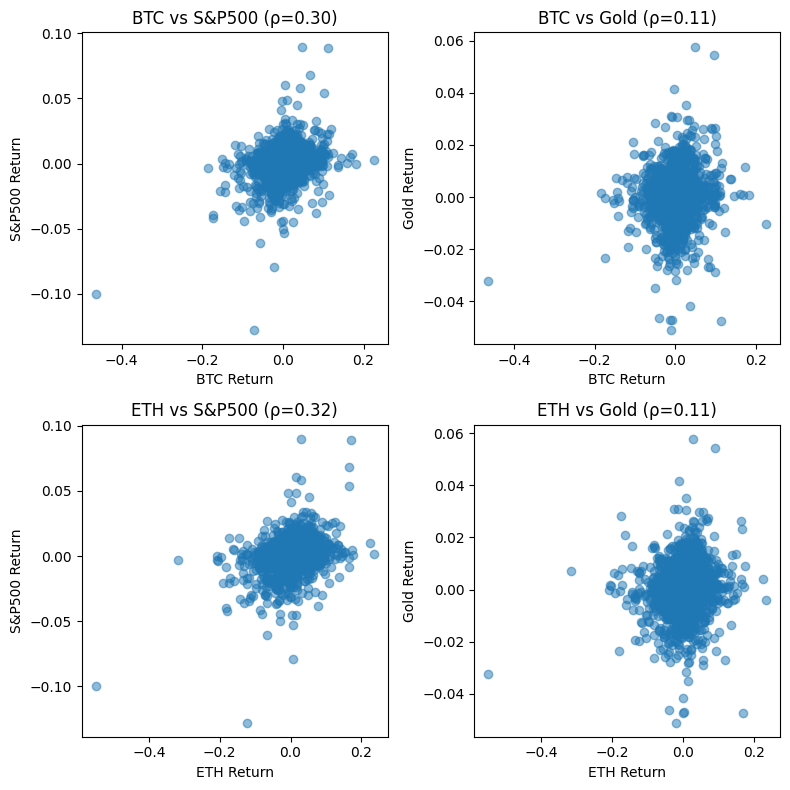

In [104]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
pairs = [('BTC', 'S&P500'), ('BTC', 'Gold'), ('ETH', 'S&P500'), ('ETH', 'Gold')]
for ax, (x, y) in zip(axes.flatten(), pairs):
    ax.scatter(combined[x], combined[y], alpha=0.5)
    ax.set_xlabel(f'{x} Return')
    ax.set_ylabel(f'{y} Return')
    # Compute correlation coefficient for annotation (rho)
    rho = combined[x].corr(combined[y])
    ax.set_title(f'{x} vs {y} (ρ={rho:.2f})')
plt.tight_layout()
plt.savefig('eda_figures/crypto_vs_traditional_scatter.png', dpi=300)
plt.show()
plt.close()

The plotted figure complements the correlation analysis by showing pairwise scatter plots of returns for crypto vs. traditional aset pairs. Each subplot plots the daily returns of one cryptocurrency against one traditional asset. We can see that the points are fairly dispersed with no clear linear relationship in the BTC vs S&P 500 and BTC vs Gold plots, reflecting the low correlations mentioned above. Similarly, ETH vs S&P 500 and ETH vs Gold show widely scattered points. There is no strong co-movement pattern, which visually reinforces that crypto returns have largely been independent from equity and gold returns on a day-to-day basis.

# High-Low price spread over time (intraday range)

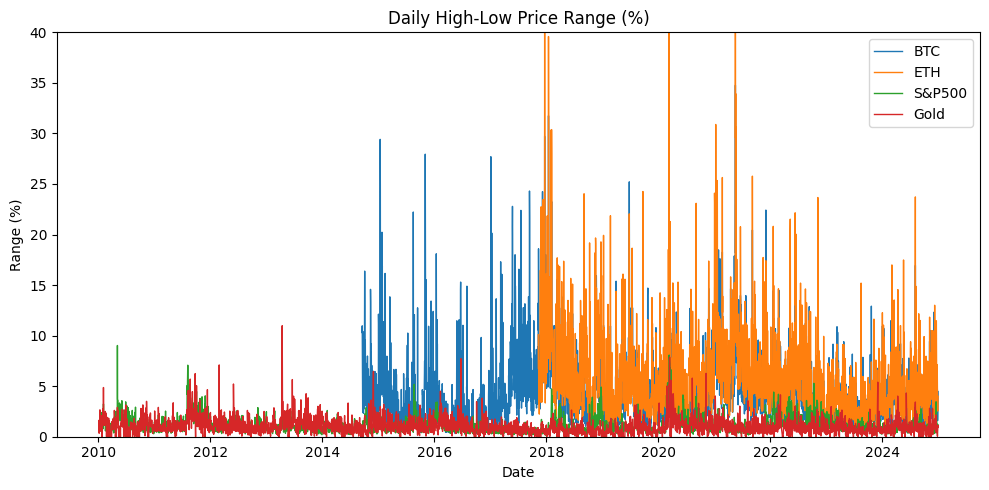

In [105]:
plt.figure(figsize=(10, 5))
for i, (name, df) in enumerate(assets.items()):
    # Calculate daily range (High - Low). Use Close if available for normalization.
    if name == 'VIX':
        continue

    if 'Close' in df.columns:
        spread_pct = (df['High'] - df['Low']) / df['Close'] * 100.0  # percent range
    else:
        spread_pct = (df['High'] - df['Low']) / df['Low'] * 100.0
    if 'Date' in df.columns:
        df_index = df.set_index('Date').index
    else:
        df_index = df.index
    plt.plot(df_index, spread_pct, label=name, linewidth=1.0)
plt.title('Daily High-Low Price Range (%)')
plt.xlabel('Date')
plt.ylabel('Range (%)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.ylim(0, 40)
plt.savefig('eda_figures/high_low_range.png', dpi=300)
plt.show()
plt.close()

We also consider the intraday price range as another measure of volatility. We plot the daily high-low price spread as a percentage of the closing price for each asset over time. This metric captures how volatile each asset is within a single day. Consistent with earlier results, BTC and ETH often have much larger intraday swings (some days the range exceeds 5-10% of price) compared to the S&P 500 or Gold (which typically see less than 2% range on most days). The high-low spread visualization underlines that cryptocurrencies not only move more from day to day, but also exhibit higher volatility within each day. These findings underscore that crypto markets experience extreme fluctuations in short time frames, where traditional markets are relatively more stable intraday. Observing the persistently higher ranges for BTC and ETH further reinforces the need for models that can handle such volatility for instance GARCH-type models, as discussed in Tsay (2010, Ch. 3) for conditional heteroskedasticity.

The EDA shows that cryptocurrencies are far more volatile than traditional financial assets on both an interday and intraday basis. Bitcoin and Ethereum returns have higher standard deviations and more frequent extreme values. All assets show near-zero mean returns and little autocorrelation in returns. We observe volatility clusterings for BTC/ETH which suggests that GARCH-type models (Tsay, 2010, Ch. 3) may be appropriate to capture conditional heteroscedasticity. In terms of interdependence, crypto returns have low correlation with stocks and gold, implying potential diversification benefits. However, one should be cautious because correlations can spike during market crises, meaning crypto and traditional assets might all tumble together under extreme conditions. These insights set the stage for the subsequent modeling and risk analysis, where we will delve deeper into volatility modeling and forecasting using ARCH/GARCH models  and discussing implications for investors.

## ADF

In [106]:
# ADF test for stationarity
# Define the dataframes and their names
df_list = [btc_df, eth_df, sp500_df, vix_df, gold_df]
names = ['BTC', 'ETH', 'SP500', 'VIX', 'GOLD']

def adf_test(series, title=''):
    result = adfuller(series)
    if result[1] <= 0.05:
        print(f'{title} Series is Stationary')
    else:
        print(f'{title} Series is Non-Stationary')

# Perform ADF test on the "Return" column for each dataframe
for name, df in zip(names, df_list):
    adf_test(df["Return"], title=name)


BTC Series is Stationary
ETH Series is Stationary
SP500 Series is Stationary
VIX Series is Stationary
GOLD Series is Stationary


## Univariate Model: ARIMA

In this section, we conduct a detailed univariate ARIMA analysis on the log return series of Bitcoin and Ethereum. Our aim is to determine whether the return series exhibit any time-dependent structure that could be useful for forecasting. We begin by testing for stationarity, then examine the autocorrelation structure, and finally perform model selection based on both the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC).

In [107]:
# Load in datasets
df_btc = pd.read_csv('../data/btc_data.csv')
df_eth = pd.read_csv('../data/eth_data.csv')
df_sp500 = pd.read_csv('../data/sp500_data.csv')
df_vix = pd.read_csv('../data/vix_data.csv')
df_gold = pd.read_csv('../data/gold_data.csv')

In [108]:
for df in [df_btc, df_eth, df_sp500, df_vix, df_gold]:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

## Stationarity Testing

We have used the Augmented Dickey-Fuller (ADF) test on the log return series of both Bitcoin and Ethereum. Since both p-values are below 0.05, we conclude that the log return series for Bitcoin and Ethereum are stationary.


## Univariate

## ACF and PACF Analysis

After confirming stationarity, we examine the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) plots to investigate potential autoregressive (AR) and moving average (MA) components. The ACF plot provides insight into the overall correlation structure between lagged observations, while the PACF plot reveals the correlation of the series with its lagged values after removing the influence of earlier lags.


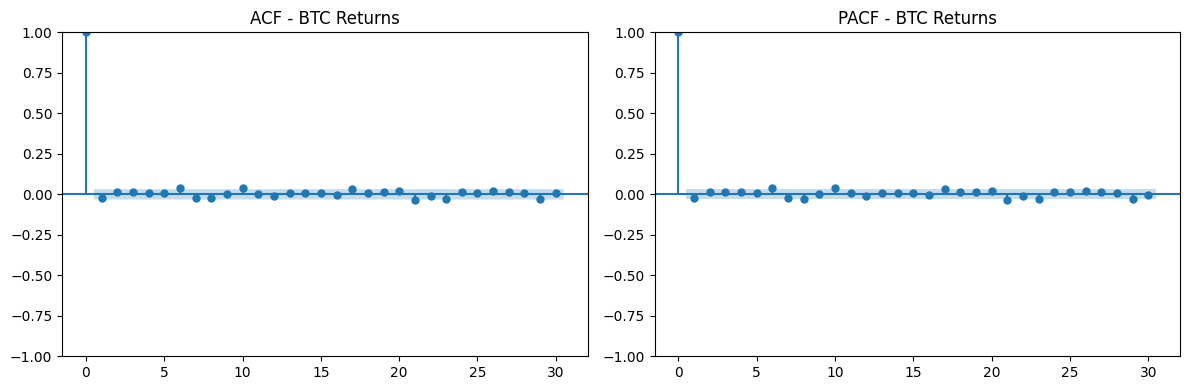

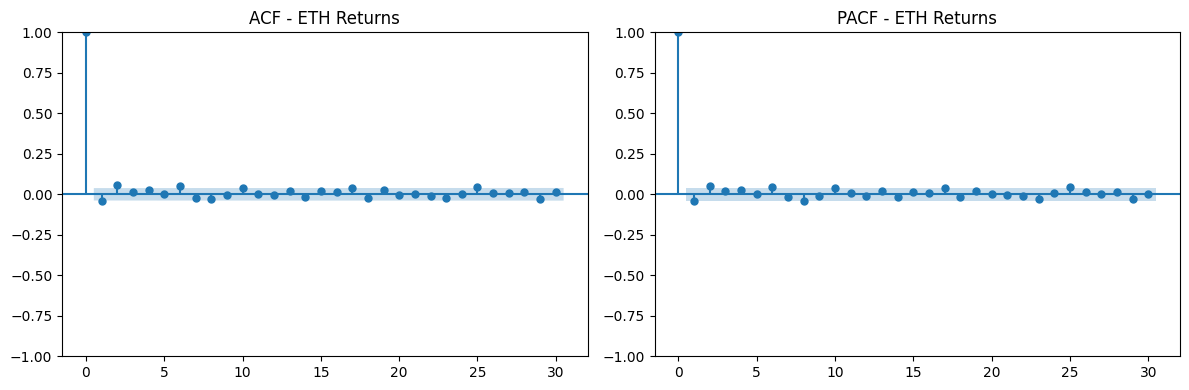

In [109]:
# BTC plots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_btc['Return'].dropna(), ax=ax[0], lags=30)
ax[0].set_title('ACF - BTC Returns')
plot_pacf(df_btc['Return'].dropna(), ax=ax[1], lags=30, method='ywm')
ax[1].set_title('PACF - BTC Returns')
plt.tight_layout()
plt.show()

# ETH plots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_eth['Return'].dropna(), ax=ax[0], lags=30)
ax[0].set_title('ACF - ETH Returns')
plot_pacf(df_eth['Return'].dropna(), ax=ax[1], lags=30, method='ywm')
ax[1].set_title('PACF - ETH Returns')
plt.tight_layout()
plt.show()


For both Bitcoin and Ethereum, the ACF and PACF plots suggest that there is no significant autocorrelation beyond lag 0. This visual evidence supports the hypothesis that the log return series do not exhibit a meaningful time-dependent structure that could be captured by additional AR or MA terms.
The absence of significant autocorrelations beyond lag 0 reinforces the view that the series can be modeled as white noise without any need for further AR or MA components

## Model Selection Using AIC and BIC

To quantitatively support the visual analysis, we perform a grid search over different combinations of the ARIMA parameters p (autoregressive order) and q (moving average order) while keeping d = 0. Each model is evaluated using the AIC and BIC, which balance the quality of the model fit with its complexity. While the AIC tends to favor slightly more complex models, the BIC imposes a stronger penalty on complexity. 


In [110]:
import warnings
warnings.filterwarnings("ignore")  # Hide convergence warnings

btc_aic_bic_results = []

# Try values from 0 to 4 for p and q
for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(df_btc['Return'].dropna(), order=(p, 0, q))  # d=0 for returns
            result = model.fit()
            btc_aic_bic_results.append({
                'p': p,
                'q': q,
                'AIC': result.aic,
                'BIC': result.bic,
        
            })
        except:
            continue

# Convert to DataFrame and sort
btc_aic_bic_df = pd.DataFrame(btc_aic_bic_results)
print(btc_aic_bic_df)  # Show top 10 models



    p  q           AIC           BIC
0   0  0 -14222.409770 -14209.946486
1   0  1 -14221.894229 -14203.199302
2   0  2 -14220.442388 -14195.515819
3   0  3 -14218.966888 -14187.808677
4   0  4 -14217.417581 -14180.027728
5   1  0 -14221.933090 -14203.238163
6   1  1 -14220.142287 -14195.215719
7   1  2 -14222.034340 -14190.876129
8   1  3 -14216.897270 -14179.507417
9   1  4 -14215.543734 -14171.922238
10  2  0 -14220.406258 -14195.479689
11  2  1 -14218.422078 -14187.263868
12  2  2 -14216.427557 -14179.037704
13  2  3 -14214.557683 -14170.936188
14  2  4 -14213.617603 -14163.764465
15  3  0 -14219.017750 -14187.859539
16  3  1 -14217.028787 -14179.638934
17  3  2 -14215.019762 -14171.398267
18  3  3 -14212.512036 -14162.658898
19  3  4 -14214.734774 -14158.649994
20  4  0 -14217.489815 -14180.099962
21  4  1 -14215.498906 -14171.877411
22  4  2 -14213.476720 -14163.623582
23  4  3 -14213.529196 -14157.444417
24  4  4 -14212.231560 -14149.915138


In [111]:
eth_aic_bic_results = []

# Try values from 0 to 4 for p and q
for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(df_eth['Return'].dropna(), order=(p, 0, q))  # d=0 for returns
            result = model.fit()
            eth_aic_bic_results.append({
                'p': p,
                'q': q,
                'AIC': result.aic,
                'BIC': result.bic
            })
        except:
            continue

# Convert to DataFrame and sort
eth_aic_bic_df = pd.DataFrame(eth_aic_bic_results)
print(eth_aic_bic_df)  # Show top 10 models


    p  q          AIC          BIC
0   0  0 -8628.669483 -8616.936039
1   0  1 -8630.719297 -8613.119130
2   0  2 -8636.864592 -8613.397703
3   0  3 -8635.599503 -8606.265892
4   0  4 -8635.452379 -8600.252045
5   1  0 -8631.187234 -8613.587067
6   1  1 -8634.627444 -8611.160555
7   1  2 -8636.595511 -8607.261900
8   1  3 -8633.442430 -8598.242097
9   1  4 -8633.507015 -8592.439959
10  2  0 -8636.828658 -8613.361769
11  2  1 -8637.900202 -8608.566591
12  2  2 -8635.425348 -8600.225015
13  2  3 -8635.546711 -8594.479655
14  2  4 -8632.318632 -8585.384854
15  3  0 -8635.949033 -8606.615422
16  3  1 -8634.007217 -8598.806883
17  3  2 -8634.956937 -8593.889881
18  3  3 -8633.715320 -8586.781541
19  3  4 -8629.818967 -8577.018467
20  4  0 -8635.996085 -8600.795751
21  4  1 -8633.999504 -8592.932448
22  4  2 -8633.162549 -8586.228770
23  4  3 -8631.134017 -8578.333517
24  4  4 -8635.738686 -8577.071463


For Bitcoin, the grid search resulted in the following AIC values: ARIMA(0,0,0) produces an AIC of -14274.50, ARIMA(1,0,0) gives an AIC of -14274.04, and ARIMA(0,0,1) yields an AIC of -14274.01, indicating that the models perform very similarly with a slight edge for ARIMA(0,0,0). 

For Ethereum, the grid search yielded AIC values of -8628.67 for ARIMA(0,0,0), -8631.19 for ARIMA(1,0,0), and -8630.72 for ARIMA(0,0,1), suggesting that ARIMA(1,0,0) offers a marginally better fit. 
Although the differences are small, the BIC values—which impose a stronger penalty on additional parameters—tend to favor simpler models. Overall, these results imply that the log return series for both Bitcoin and Ethereum are broadly consistent with white noise behavior, with little evidence of substantial time-dependent structure in either asset.

## Multivariate analysis

In this file the linear multivariate model analysis will be performed.

The aim is to look at whether or not the traditional assets, such as gold and the S&P, have interdependencies with the cryptocurrencies, using a multivariate time-series approach. The overall goal is to look at the relationships between the assets and, specifically, explore how shocks in traditional markets might propagate through to the cryptocurrencies.

The multivariate analysis in this section will be conducted using a Vector Autoregression (VAR) model. VAR is chosen as it holds the promise of capturing dynamics and  interconnected behaviour of multiple economic variables by providing a coherent and credible  approach to data description, forecasting and structural inference according to Stock & Watson (2001). Thus, the model is considered suitable for the scope of this project, to capture any interdependencies among the multiple time-series. 


Reference:

Stock, J. H., & Watson, M. W. (2001). Vector Autoregression. Journal of Economic Perspectives, 15(4), 101-115. 10.1257/jep.15.4.101

In [112]:
# Load data
df_btc = pd.read_csv('../data/btc_data.csv')
df_eth = pd.read_csv('../data/eth_data.csv')
df_sp500 = pd.read_csv('../data/sp500_data.csv')
df_vix = pd.read_csv('../data/vix_data.csv')
df_gold = pd.read_csv('../data/gold_data.csv')

In [113]:
# Ensure consistent column names
for df in [df_btc, df_eth, df_sp500, df_vix, df_gold]:
    df.columns = df.columns.str.strip()

# Convert 'Date' to datetime
for df in [df_btc, df_eth, df_sp500, df_vix, df_gold]:
    df['Date'] = pd.to_datetime(df['Date'])

# Set index to 'Date'
for df in [df_btc, df_eth, df_sp500, df_vix, df_gold]:
    df.set_index('Date', inplace=True)

# Selecting only 'Close' prices and renaming to the
df_btc = df_btc[['Close']].rename(columns={'Close': 'BTC'})
df_eth = df_eth[['Close']].rename(columns={'Close': 'ETH'})
df_sp500 = df_sp500[['Close']].rename(columns={'Close': 'SP500'})
df_vix = df_vix[['Close']].rename(columns={'Close': 'VIX'})
df_gold = df_gold[['Close']].rename(columns={'Close': 'GOLD'})

In [114]:
# Merging all the dataframes on date
dfs = [df_btc, df_eth, df_sp500, df_gold]
df_merged = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), dfs)

# Forward-fill then backward-fill missing values to ensure consistency
df_merged.ffill(inplace=True)
df_merged.bfill(inplace=True)

In [115]:
# Transformation: Computing log returns to stabilize variance and help with stationarity
log_returns = np.log(df_merged / df_merged.shift(1)).dropna()

## Var Model

For the VAR model, the data needs to be stationary, which we found out in the EDA.


The choice of VAR model is determined using the Akaike Information Criterion (AIC) as the complexity of the dataset, number of datapoints and the goal of exploring how shocks in the different assets propagate to the others require a high level of detail captured in the model. The tradeoff is the risk of overfitting, however this risk is outbalanced be the need for details in the analysis.

In [116]:
# Vector Autoregression (VAR) Model

# Fitting the VAR model on the log returns
model = VAR(log_returns)

# Lag Order Selection using criteria AIC (Can also check BIC, HQIC, etc.)
lag_order_results = model.select_order(maxlags=15)
print("Lag Order Selection Criteria:")
print(lag_order_results.summary())

# Selecting the optimal lag based on AIC.
optimal_lag = lag_order_results.aic
print("Optimal Lag Order:", optimal_lag)

Lag Order Selection Criteria:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -33.10     -33.09*   4.230e-15      -33.09
1       -33.11      -33.08   4.183e-15     -33.10*
2       -33.11      -33.06   4.180e-15      -33.09
3       -33.11      -33.04   4.192e-15      -33.08
4       -33.11      -33.02   4.188e-15      -33.08
5       -33.11      -33.00   4.184e-15      -33.07
6       -33.11      -32.98   4.172e-15      -33.06
7       -33.11      -32.95   4.185e-15      -33.05
8       -33.11      -32.94   4.158e-15      -33.05
9       -33.11      -32.92   4.157e-15      -33.05
10      -33.11      -32.90   4.155e-15      -33.04
11     -33.12*      -32.88  4.140e-15*      -33.03
12      -33.12      -32.86   4.152e-15      -33.02
13      -33.12      -32.84   4.152e-15      -33.02
14      -33.12      -32.82   4.147e-15      -33.01
15      -33.11      -32.79   4.158e-15      -33.00
-

The optimal lag order based on the AIC criterion suggests that past information from 11 days is most useful for modeling the current dynamics. 

Now that the optimal lag is identified, the VAR model is fitted to the log return series. The summary output from the VAR model provides estimated coefficients that describe how the past values of one asset help explain the current values of another. This model specification includes not only the coefficient estimates but also various diagnostic statistics that are used to assess model performance.


In [117]:
# Fitting the VAR model with optimal lag according to AIC
results_var = model.fit(optimal_lag)
print(results_var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Apr, 2025
Time:                     19:29:16
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -32.8820
Nobs:                     4930.00    HQIC:                  -33.0361
Log likelihood:           53837.8    FPE:                4.13460e-15
AIC:                     -33.1194    Det(Omega_mle):     3.98702e-15
--------------------------------------------------------------------
Results for equation BTC
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000958         0.000458            2.092           0.036
L1.BTC            0.033763         0.019150            1.763           0.078
L1.ETH           -0.074510         0.018267           -4.079           0.000
L

The Ljung Box test is performed, for residual diagnostics, on the residuals of each asset's equation separately to check for autocorrelation. 
Ideally, the residuals should resemble white noise, which would indicate that the VAR model has adequately captured the dynamics in the data. 

In [118]:
# Diagnostics: Check for residual autocorrelation using the Ljung-Box test
# Convert residuals to a DataFrame with proper column names and index
resid_df = pd.DataFrame(results_var.resid, 
                        index=log_returns.index[results_var.k_ar:], 
                        columns=log_returns.columns)

# Run Ljung-Box test on each column separately
for col in resid_df.columns:
    lb_test = acorr_ljungbox(resid_df[col], lags=[10], return_df=True)
    print(f"Ljung-Box Test for {col}:")
    print(lb_test)
    # Check the p-value
    if lb_test['lb_pvalue'].iloc[0] < 0.05:
        print(f"Reject null hypothesis: Significant autocorrelation in {col} residuals.")
    else:
        print(f"Fail to reject null hypothesis: No significant autocorrelation in {col} residuals.")
    print("\n")

#Interpretation of the Ljung-Box test results:
# The null hypothesis of the Ljung-Box test is that there is no autocorrelation in the residuals.
# If the p-value is less than 0.05, we reject the null hypothesis, indicating that there is significant autocorrelation.
# If the p-value is greater than 0.05, we fail to reject the null hypothesis, indicating that there is no significant autocorrelation.


Ljung-Box Test for BTC:
     lb_stat  lb_pvalue
10  0.038078        1.0
Fail to reject null hypothesis: No significant autocorrelation in BTC residuals.


Ljung-Box Test for ETH:
     lb_stat  lb_pvalue
10  0.064757        1.0
Fail to reject null hypothesis: No significant autocorrelation in ETH residuals.


Ljung-Box Test for SP500:
    lb_stat  lb_pvalue
10  1.68363    0.99824
Fail to reject null hypothesis: No significant autocorrelation in SP500 residuals.


Ljung-Box Test for GOLD:
     lb_stat  lb_pvalue
10  0.243893        1.0
Fail to reject null hypothesis: No significant autocorrelation in GOLD residuals.




The p-values are close to, or equal to 1. Thus, it is statistically sound to conclude that the residuals are not significantly autocorrelated and that they indeed resemble white noise.

Further, the stability of the VAR model is verified by examining the eigenvalues of the companion matrix. 
All eigenvalues should lie within the unit circle (i.e., have absolute values less than one), confirming that the model is stable over time.

In [119]:
# Checking the stability using eigenvalues (all should be less than 1 in absolute value)

# Computing eigenvalues from the companion matrix
coefs = results_var.coefs  # Coefficients of the VAR model
k = coefs.shape[1]  # Number of variables
p = coefs.shape[0]  # Number of lags
comp_matrix = np.zeros((k * p, k * p))  # Initialize companion matrix
comp_matrix[:k, :] = coefs.reshape(k, -1)  # Fill the first block with coefficients
if p > 1:
    comp_matrix[k:, :-k] = np.eye(k * (p - 1))  # Fill the lower diagonal with identity matrix

eigenvalues = np.linalg.eigvals(comp_matrix)

# Check if all eigenvalues are less than 1 in absolute value
stable = np.all(np.abs(eigenvalues) < 1)
print("Is the VAR model stable? (All eigenvalues < 1 in absolute value):", stable)


Is the VAR model stable? (All eigenvalues < 1 in absolute value): True


## Impulse Response Function Plots

Further, constructing Impulse Response Function (IRF) plots will help in visualising and analysing how shocks propagate between the asset groups.

The IRF plots are effective, as they trace and visualise the effect of a one-unit shock in one variable on the future values of all variables in the system. 

They help visualize how, for instance, a shock to the S&P 500 might affect the Bitcoin returns over the chosen timeframe of 11 days. 

In the plot the blue line represents the response magnitude, while the dotted black lines represent confidence intervals. If the confidence intervals include zero, the response is not considered statistically significant.

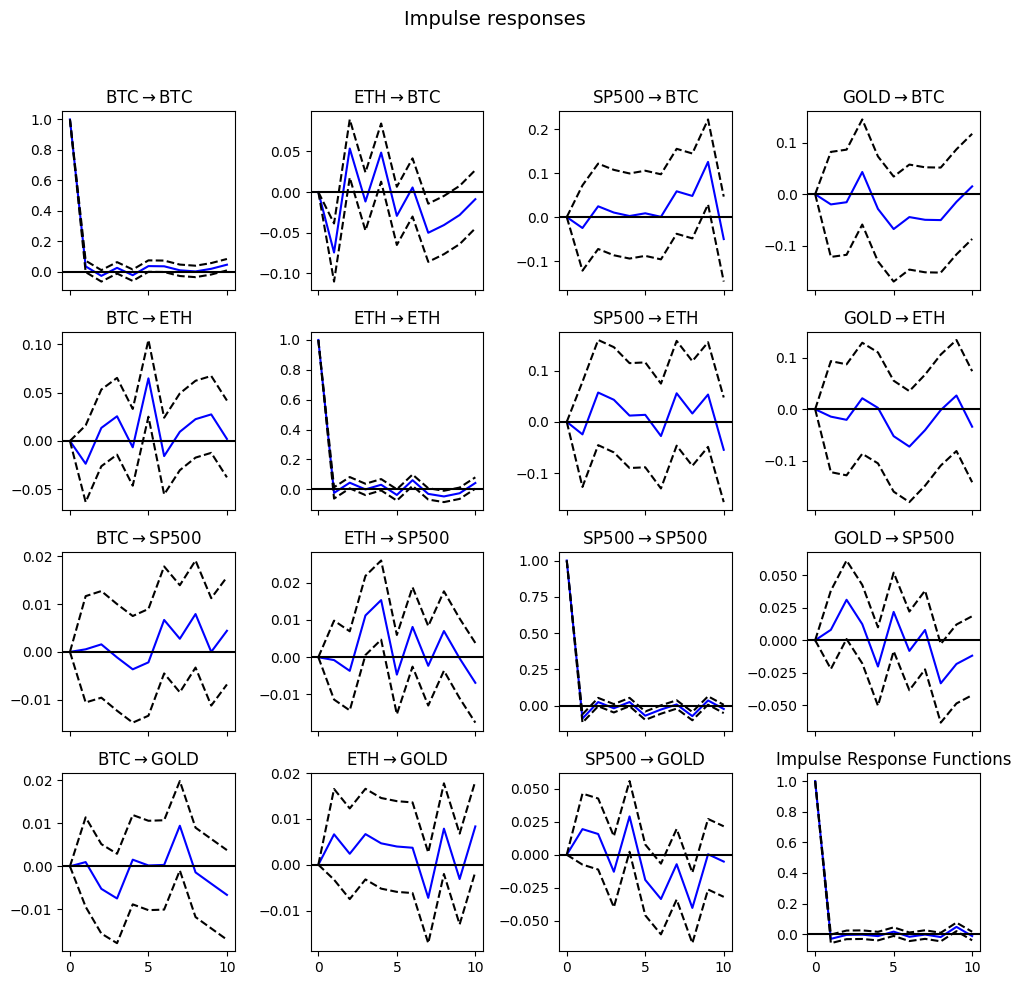

In [120]:
# Impulse Response Functions (IRFs)
irf = results_var.irf(10)  # 10 periods ahead
irf.plot(orth=False)
plt.title("Impulse Response Functions")


# Tidy up layout so titles/labels don’t overlap
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

Looking at the shocks' effect between the traditional assets and the cryptocurrencies. iT becomes apparent that the shocks originating from the S&P 500 and Gold, do not significantly propagate to the cryptocurrency markets (BTC and ETH) in the 11-day horizon analyzed here. We see, however, some propagation of shocks to the S&P 500, propagating to bitcoin at some of the higher lags. Another noteworthy finding is that lagged Ethereum terms seems to have some effect on the S&P 500, indicating some spillover from the cryptocurrency to the equity markets.

Otherwise, the observed effects are weak, and statistically insignificant, suggesting that the cryptocurrency markets are relatively independent, at least in the short term, from the direct influence of shocks occurring in the S&P 500 and Gold and vice versa.

The model also captures dynamics between the cryptocurrencies as well. And as would be expected Bitcoin returns are heavily influenced by past Ethereum movements, and Ethereum shows significant dependence on lagged bitcoin returns. This indicates mutual crypto-market dependencies, something that is to be expected, given their similar risk exposure.

Assumptions:
The VAR model assumes linear relationships among the log return series.
All time series are stationary (log returns typically satisfy this).
Residuals are assumed to be uncorrelated (white noise).
Limitations:
External shocks or structural breaks are not explicitly modeled.
Multicollinearity among highly correlated variables may affect coefficient interpretability.
The model’s performance can be sensitive to the selected lag order and sample period.
Nonlinear interactions are not captured by a linear VAR framework.

## Modelling volatility using GARCH

Generalized Autoregressive Conditional Hetereoskedasticity) model is a statistical model used for modelling and forecasting the variance of time series data, and is widely known for use in financial markets. We have already mentioned the concept of an autoregressive process in ARMA-models where current returns depends on past returns. For GARCH-models, the conditional variance of a time series is modelled based on values of past variance terms and past squared residuals. As with the ARMA model-selection, information criterias such as AIC, SBIC and HQIC can be used for the selection of the GARCH(p,q) parameters;

p: the number of lags of the conditional variance  
q: the number of lags of the squared residuals

In this section, we will explore whether a GARCH model can effectively capture the volatility of the two major cryptocurrencies in this report, Bitcoin (BTC) and Ethereum (ETH). We will then compare the results before applying the same approach to S&P 500 and gold returns.

### Reasoning for choosing to model using GARCH

After studying the various models available for modeling volatility, we decided to use GARCH. Although we could have first attempted to model the volatility with ARCH, we chose to skip this step since GARCH is a natural extension of the ARCH model. ARCH has well-known limitations, including the challenge of determining the optimal number of lags for the squared residuals and the potential need for a large number of parameters to capture all the conditional variance dependence (Brooks, 2019, P.511). With a high number of lags, the likelihood of violating the non-negativity constraint in ARCH models also increases. Furthermore, GARCH models are more widely used in practice, making it an obvious choice for our analysis (Brooks, 2019, p. 511).

### Pre-analysis
Before proceeding with the volatility modelling, we first want to highlight a few key characteristics observed in the return plots of the assets shown in the Data Analysis section. These include volatility clustering, volatility spikes, and mean-reverting behaviour.

First, volatility clustering, also known as volatility pooling,  refers to the tendency for large positive returns to be followed by large positive returns, and large negative returns to be followed by large negative returns (Brooks, 2019, p. 498). This pattern, commonly seen in financial markets, is clearly visible in the return plots of all assets in our dataset. The returns tend to form distinct periods of high and low volatility, giving them a wave-looking appearance. This is a symptom of heteroskedasticity and is explicitly accounted for with GARCH, due to modelling the current condtional variance based on previous conditional variance.

Secondly, we also see that volatility during negative returns tends to be larger than during positive returns. This asymmetry is known as the leverage effect (Brooks, 2019, p.498). The leverage effect is not accounted for by standard GARCH but can be captured by the EGARCH model (Brooks, 2019, p. 522–523). However, since the effect appears small in the plots from the Data Analysis section, we leave exploring EGARCH for future research.

Lastly, we observe that all assets have constants mean around zero and that returns revert towards the mean. Therefore, the variance shocks also reverts after larger shocks. This is important because it implies that the unconditional variance remains stationary despite heteroskedasticity. Therefore, we must ensure that our GARCH parameters do not result in a non-stationary variance or introduce unit roots, as this would prevent the volatility shocks from reverting after larger shocks (Brooks, 2019, p. 514-515). 





### Information Criteria

**Function for computing Information Criterias**

In [121]:
def informationCriteriasGARCH(df, p_range, q_range):
    #df['Date'] = pd.to_datetime(df['Date'])
    #df.set_index('Date', inplace=True)

    # Here we defined the values we want to iterate through for p and q
    p_range = range(1, p_range)
    q_range = range(1, q_range)

    results = []

    # Here we loop over all combinations of p and q, and calculate the AIC, SBIC and HQIC for each GARCH(p,q)
    for p in p_range:
        for q in q_range:
            # Here we multiplied return by 100 to prevent small-values, making the optimization more stable.
            model = arch_model((df['Return']*100).dropna(), vol='Garch', p=p, q=q)
            garch_fit = model.fit(disp="off")  # Suppress output

            # Here we compute HQIC manually, since the library does not support HQIC
            log_likelihood = garch_fit.loglikelihood
            num_obs = len(df['Return'].dropna())
            num_params = p + q + 1
            hqic = -2 * log_likelihood + 2.0 * num_params * np.log(np.log(num_obs))

            # Store the results
            results.append([p, q, garch_fit.aic, garch_fit.bic, hqic])
            
    garch_results_df = pd.DataFrame(results, columns=['p', 'q', 'AIC', 'SBIC', 'HQIC'])
    print(garch_results_df)

    best_aic = garch_results_df.loc[garch_results_df['AIC'].idxmin()]
    best_sbic = garch_results_df.loc[garch_results_df['SBIC'].idxmin()]
    best_hqic = garch_results_df.loc[garch_results_df['HQIC'].idxmin()]

    print("\nBest model based on AIC:")
    print(best_aic[0:2])
    print("\nBest model based on SBIC:")
    print(best_sbic[0:2])
    print("\nBest model based on HQIC:")
    print(best_hqic[0:2])

We constructed a table testing the AIC, SBIC, and HQIC scores on GARCH(p, q) for all permutations of the p and q parameters. To account for computational complexity, we only tested for p and q less than 10. In all cases except for gold, the information criteria suggested different optimal parameters. However, since we wanted to favor fewer parameters and the datasets are relatively large, we concluded that always following the SBIC criterion would be optimal, as it imposes a stricter penalty term (Brooks, 2019, p. 360-361)

**Function for fitting a GARCH model and printing the summary**

In [122]:
def fitGARCH(df,p,q):
    # Keep in mind that the information criteria will be scaled different in this summary, due to not scaling the Return
    model = arch_model(df['Return'].dropna(), vol='Garch', p=p, q=q, rescale=False)
    garch_fit = model.fit()
    print(garch_fit.summary())
    return garch_fit

**Function for plotting the GARCH model against the return for comparison**

In [123]:
def plot_results(garch, df):
    conditional_volatility = garch.conditional_volatility

    # We trim to make the lengths of the dataframes match.
    df_trimmed = df.iloc[len(df)-len(conditional_volatility):]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # GARCH Conditional volatility
    ax1.plot(df_trimmed.index, conditional_volatility, color='tab:red', label='Conditional Volatility (GARCH)', linewidth=1)
    ax1.set_ylabel('Conditional Volatility')
    ax1.set_title('Conditional Volatility from GARCH Model')
    ax1.legend(loc='upper left')

    # Return
    ax2.plot(df_trimmed.index, df_trimmed['Return'], color='tab:blue', label='Return', linewidth=1)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Return')
    ax2.set_title('Regular Returns')
    ax2.legend(loc='upper left')

    fig.tight_layout()
    plt.show()

### GARCH Modelling Bitcoin (BTC)

In [124]:
informationCriteriasGARCH(btc_df,10,10)

    p  q           AIC          SBIC          HQIC
0   1  1  19755.917294  19780.843863  19760.565208
1   1  2  19754.296954  19785.455164  19761.160838
2   1  3  19722.057133  19759.446986  19731.136988
3   1  4  19724.057133  19767.678628  19735.352959
4   1  5  19726.057133  19775.910270  19739.568930
.. .. ..           ...           ...           ...
76  9  5  19712.860046  19812.566321  19744.099612
77  9  6  19709.950574  19815.888491  19743.406111
78  9  7  19711.950575  19824.120134  19747.622083
79  9  8  19713.950574  19832.351776  19751.838053
80  9  9  19715.950574  19840.583418  19756.054024

[81 rows x 5 columns]

Best model based on AIC:
p    4.0
q    4.0
Name: 30, dtype: float64

Best model based on SBIC:
p    1.0
q    3.0
Name: 2, dtype: float64

Best model based on HQIC:
p    4.0
q    4.0
Name: 30, dtype: float64


In [125]:
btc_GARCH = fitGARCH(btc_df,1,3)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 16878098087128.59
Iteration:      2,   Func. Count:     22,   Neg. LLF: -2432.517687832095
Iteration:      3,   Func. Count:     32,   Neg. LLF: 16209.667492779545
Iteration:      4,   Func. Count:     43,   Neg. LLF: -2589.975472809392
Iteration:      5,   Func. Count:     53,   Neg. LLF: 15939.031732879339
Iteration:      6,   Func. Count:     62,   Neg. LLF: -6218.558181350064
Iteration:      7,   Func. Count:     70,   Neg. LLF: -7334.906662633517
Iteration:      8,   Func. Count:     78,   Neg. LLF: -5965.225335666764
Iteration:      9,   Func. Count:     86,   Neg. LLF: 16343.925487536879
Iteration:     10,   Func. Count:     94,   Neg. LLF: -5881.05682660793
Iteration:     11,   Func. Count:    104,   Neg. LLF: -7317.099134378378
Iteration:     12,   Func. Count:    112,   Neg. LLF: -7238.709345896938
Iteration:     13,   Func. Count:    121,   Neg. LLF: -7450.148188615953
Iteration:     14,   Func. Count:    128,   Neg. LLF:

In [126]:
fitGARCH(btc_df,1,1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.639589733336044e+18
Iteration:      2,   Func. Count:     17,   Neg. LLF: -7404.833428689006
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7404.833399268857
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7404.83
Distribution:                  Normal   AIC:                          -14801.7
Method:            Maximum Likelihood   BIC:                          -14776.7
                                        No. Observations:                 3758
Date:                Sat, Apr 05 2025   Df Residuals:                     3757
Time:      

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7404.83
Distribution:                  Normal   AIC:                          -14801.7
Method:            Maximum Likelihood   BIC:                          -14776.7
                                        No. Observations:                 3758
Date:                Sat, Apr 05 2025   Df Residuals:                     3757
Time:                        19:29:30   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.7772e-03  6.087e-04      2.920  3.505e-03 [5.

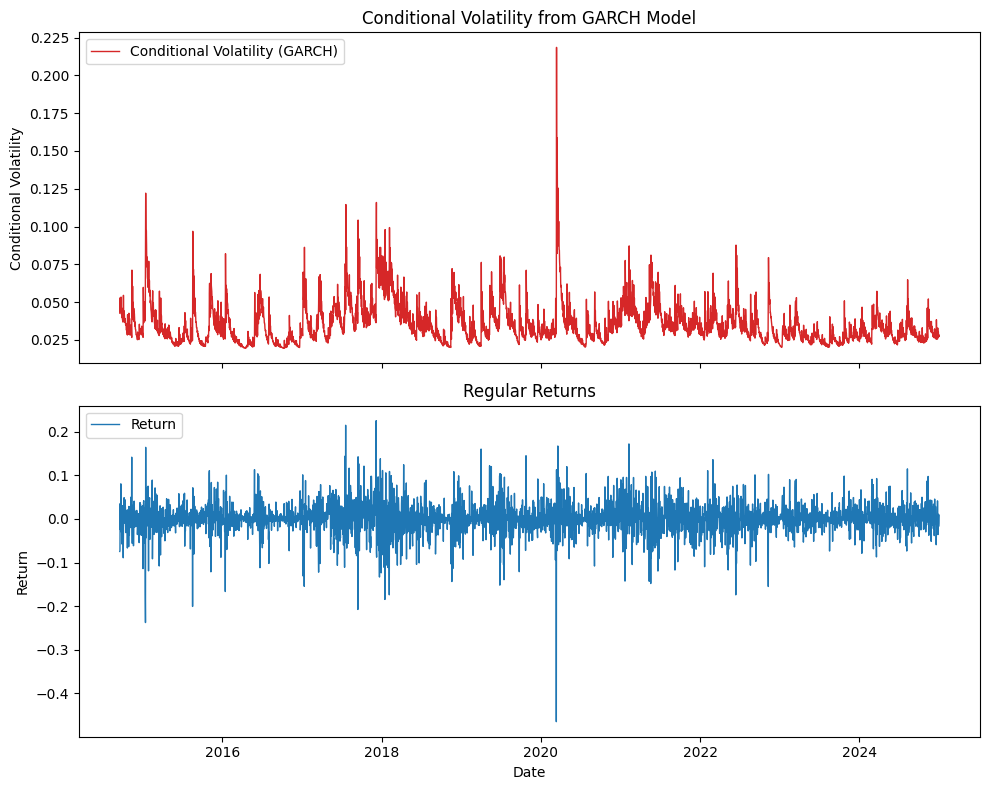

In [127]:
plot_results(btc_GARCH, btc_df)

**Bitcoin:** 
* Optimal parameter values according to BIC:   p=1, q=3
* All parameters except β_2 are significant at the 0.05 confidence level.
* Model is stationarity in variance.

The information criteria indicates that the model might be a good fit, however the insignificance of β_2 suggests that further refinement and comparison with other models could provide a better model. Therefore, we tried to compare the GARCH(1,3) model with a GARCH(1,1) model for this asset. This change resulted in a reduction in the log-likelihood indicating a worse fit. Based on this observation, we decided to stick with the GARCH(1,3) model and concluded that a better-fitting model might be found outside the standard GARCH framework, which we as previously mentioned have left for future research.

As we see on the plots comparing the GARCH(1,3) model with the returns, the model captures volatility clustering well, with higher conditional volatility during periods of large returns. All sharp spikes seems to be caught by the model, which indicates a seemingly good fit. However, as discussed exploring EGARCH or other extensions could improve fit, and should be furthered research in the future.


### GARCH Modelling Ethereum (ETH)

In [128]:
informationCriteriasGARCH(eth_df,10,10)

    p  q           AIC          SBIC          HQIC
0   1  1  15018.412072  15041.878961  15022.787921
1   1  2  15018.992462  15048.326074  15025.493594
2   1  3  15001.525560  15036.725893  15010.151975
3   1  4  15003.525560  15044.592616  15014.277258
4   1  5  15005.525560  15052.459339  15018.402541
.. .. ..           ...           ...           ...
76  9  5  15021.814668  15115.682225  15051.693913
77  9  6  15012.421188  15112.155467  15044.425716
78  9  7  15013.278694  15118.879695  15047.408505
79  9  8  15015.641830  15127.109553  15051.896924
80  9  9  15010.634968  15127.969414  15049.015345

[81 rows x 5 columns]

Best model based on AIC:
p    4.0
q    9.0
Name: 35, dtype: float64

Best model based on SBIC:
p    1.0
q    3.0
Name: 2, dtype: float64

Best model based on HQIC:
p    1.0
q    3.0
Name: 2, dtype: float64


In [129]:
eth_GARCH = fitGARCH(eth_df,1,1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 405281.0802915662
Iteration:      2,   Func. Count:     18,   Neg. LLF: 9548252.27978366
Iteration:      3,   Func. Count:     29,   Neg. LLF: -4503.767858058432
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4503.767863398977
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4503.77
Distribution:                  Normal   AIC:                          -8999.54
Method:            Maximum Likelihood   BIC:                          -8976.07
                                        No. Observations:                 2609
Date:                Sa

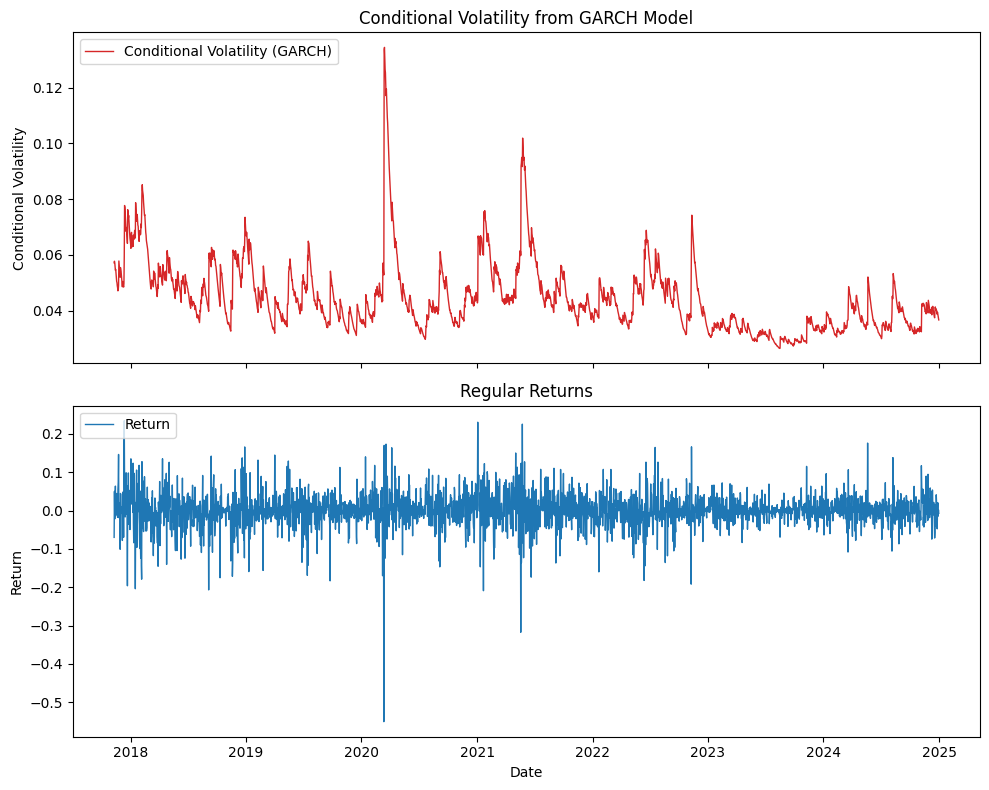

In [130]:
plot_results(eth_GARCH, eth_df)

**Ethereum:**
* Optimal parameter values according to BIC:   p=1, q=1
* All parameters are significant at the 0.05 confidence level.
* Model is stationarity in variance.

As seen in the plots, the GARCH(1,1) model captures volatility clustering well, with higher conditional volatility during large return movements. For example, the spike around 2020 aligns with increased volatility in returns, suggesting a good fit.

### GARCH Modelling S&P 500

In [131]:
informationCriteriasGARCH(sp500_df,10,10)

    p  q          AIC         SBIC         HQIC
0   1  1  9697.473377  9722.415880  9702.124193
1   1  2  9699.473377  9730.651506  9706.341132
2   1  3  9701.473377  9738.887131  9710.558071
3   1  4  9703.473377  9747.122757  9714.775009
4   1  5  9705.473377  9755.358383  9718.991948
.. .. ..          ...          ...          ...
76  9  5  9714.707684  9814.477695  9745.961764
77  9  6  9716.274118  9822.279755  9749.745137
78  9  7  9718.467516  9830.708779  9754.155473
79  9  8  9720.181025  9838.657913  9758.085921
80  9  9  9722.181025  9846.893540  9762.302860

[81 rows x 5 columns]

Best model based on AIC:
p    2.0
q    2.0
Name: 10, dtype: float64

Best model based on SBIC:
p    1.0
q    1.0
Name: 0, dtype: float64

Best model based on HQIC:
p    1.0
q    1.0
Name: 0, dtype: float64


In [132]:
sp500_GARCH = fitGARCH(sp500_df,1,1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 130123971873.53839
Iteration:      2,   Func. Count:     19,   Neg. LLF: -12511.555339662515
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12511.555357599285
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                12511.6
Distribution:                  Normal   AIC:                          -25015.1
Method:            Maximum Likelihood   BIC:                          -24990.2
                                        No. Observations:                 3773
Date:                Sat, Apr 05 2025   Df Residuals:                     3772
Time:       

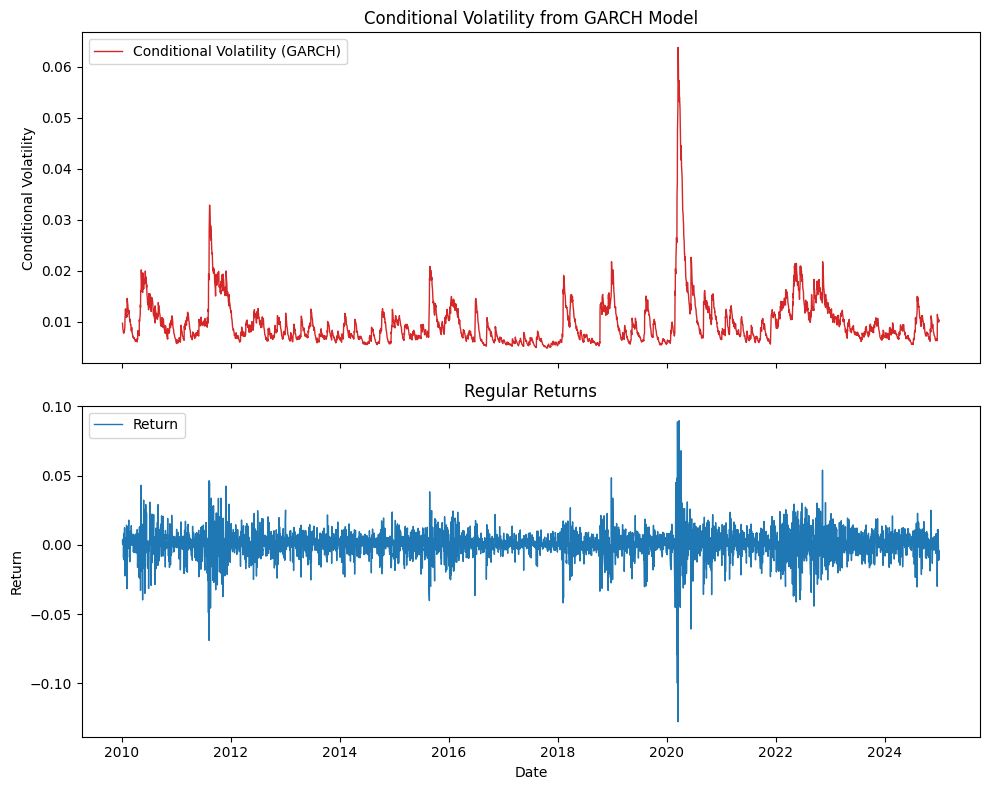

In [133]:
plot_results(sp500_GARCH, sp500_df)

**S&P500:**
* Optimal parameter values according to BIC:   p=1, q=1
* All parameters are significant at the 0.05 confidence level.
* Model is stationarity in variance.

As seen in the plots comparing the GARCH(1,1) model with the returns, the model effectively captures volatility clustering. For instance, the sharp volatility spikes following the large return swings around 2011 and 2020 are well-modeled, indicating a generally good fit.


### GARCH Modelling Gold (GC=F)

In [134]:
informationCriteriasGARCH(gold_df,10,10)

    p  q           AIC          SBIC          HQIC
0   1  1  10395.292965  10420.232286  10399.943202
1   1  2  10396.405534  10427.579686  10403.272516
2   1  3  10398.202244  10435.611226  10407.285972
3   1  4  10399.344872  10442.988684  10410.645345
4   1  5  10399.408249  10449.286891  10412.925468
.. .. ..           ...           ...           ...
76  9  5  10413.008899  10512.766184  10444.260082
77  9  6  10405.189502  10511.181617  10438.657430
78  9  7  10404.952955  10517.179901  10440.637629
79  9  8  10407.408577  10525.870352  10445.309996
80  9  9  10404.967311  10529.663917  10445.085476

[81 rows x 5 columns]

Best model based on AIC:
p    1.0
q    1.0
Name: 0, dtype: float64

Best model based on SBIC:
p    1.0
q    1.0
Name: 0, dtype: float64

Best model based on HQIC:
p    1.0
q    1.0
Name: 0, dtype: float64


In [135]:
gold_GARCH = fitGARCH(gold_df,1,1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.290480050952308e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8.861438928924047e+24
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4725931488512.339
Iteration:      4,   Func. Count:     49,   Neg. LLF: 9.724261592490526e+23
Iteration:      5,   Func. Count:     64,   Neg. LLF: 5229011886323.555
Iteration:      6,   Func. Count:     79,   Neg. LLF: 1.1088564018552676e+24
Iteration:      7,   Func. Count:     94,   Neg. LLF: 2.2996940951094407e+19
Iteration:      8,   Func. Count:    107,   Neg. LLF: 10213.879085389144
Iteration:      9,   Func. Count:    116,   Neg. LLF: 1068806212.9579448
Iteration:     10,   Func. Count:    128,   Neg. LLF: -12166.619860237974
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12166.619860937586
            Iterations: 14
            Function evaluations: 128
            Gradient evaluations: 10
                     Constant Mean - GARCH

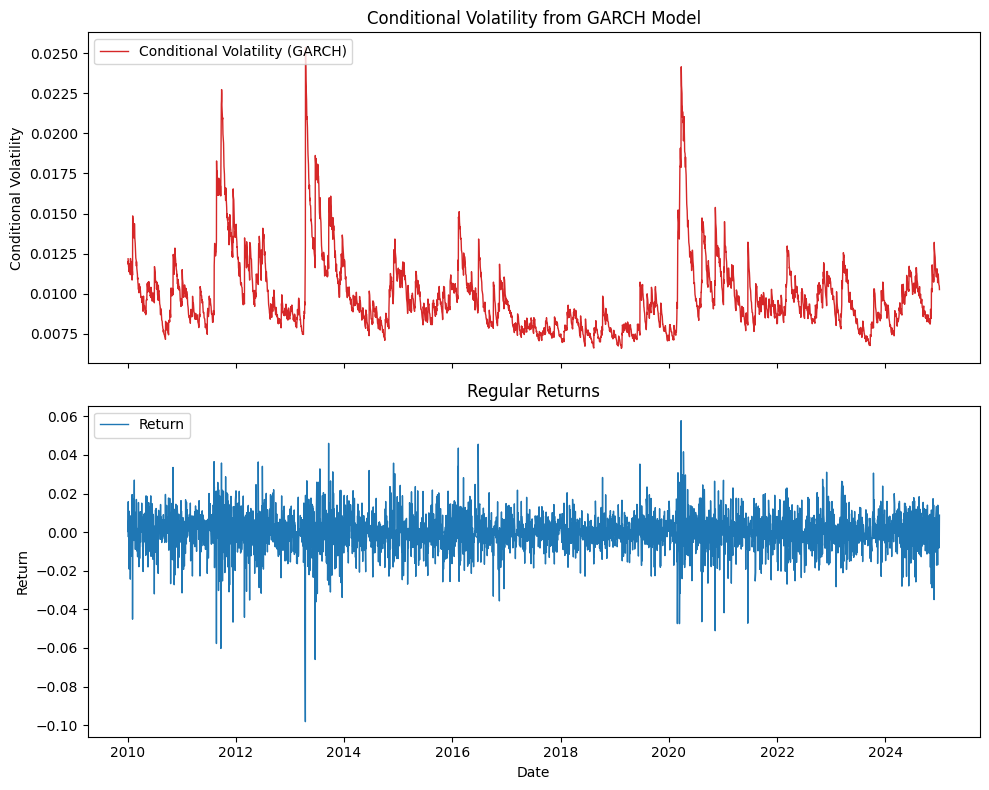

In [136]:
plot_results(gold_GARCH, gold_df)

**Gold:**
* Optimal parameter values according to BIC:   p=1, q=1
* All parameters are significant at the 0.05 confidence level.
* Model is stationarity in variance.

Again, the GARCH(1,1) models volatility effectively. However, the spikes around 2011 and 2020 appear exaggerated compared to 2013, suggesting that an extended GARCH model could provide a better fit than this general GARCH, when testing this in the future.


### Conclusion
We have managed to model the conditional variance of Bitcoin, Ethereum, S&P500 and gold using GARCH models. All models except Bitcoin obtaiend optimal results using the GARCH(1,1) model, which we expected since GARCH rarely needs any higher order than p=1 and q=1 to capture the volatility clustering in the data,  according to academic finance litterature (Brooks, 2019, p. 514).

### The use of LLMs

For this project, we used large language models to handle a few tasks. We used the Chat GPT models to help with debugging code errors in Python, check the spelling and grammar of our report, and gave us quick, plain‑English summaries of the latest research papers we needed. By offloading those chores, we could spend more time on the problem statement and subtasks themselves.

### Lesson learned

Next time, we’ll focus on making the report more structured and coherent, starting with a clearer problem statement and introduction. We got a bit carried away going straight into the exploratory data analysis without first explaining what we’re trying to investigate or why the topic is important, something that made the report a bit confusing without the one-pager. So, next time we’ll begin with a short introduction that sets the context, explains the motivation behind comparing cryptocurrencies with traditional financial assets, and outlines the main questions we want to answer. That way, the reader knows what to expect and why the analysis matters. 

Additionally, for further research or if we were to do the report over again, we would conduct tests to see whether cryptocurrencies show evidence of asymmetric volatility. According to the literature, asymmetric volatility is often said to stem from the leverage effect, which is why we assumed it to be less relevant for cryptocurrencies. However, some theory suggests it is related to volatility-feedback and a correction in the stock price due to increasing volatility. Therefore, we would test this in the future.

We also want to improve the overall consistency of the report. In this version, some sections felt a bit separate from each other, and we didn’t always explain how earlier parts connected to later ones. Next time, we’ll make sure all parts of the report tie together better, and that our structure is easy to follow from beginning to end. Lastly, we plan to write a more complete conclusion. Instead of only summarizing the last section, we’ll aim to briefly recap all the key findings and reflect on what they tell us about the relationships between the different assets. This should help wrap up the analysis in a more satisfying way and leave the reader with a clearer sense of what we learned.